# Fitting $C IV$ column density
<font size=5>

Note that there are two absorption lines of CIV which near each other, and as is often the case, the two lines are blended, so that we can't fit the single line. We should fit the two lines at the same time. For the two lines, we have:

$$d\tau_1=\frac{dI_1}{I},   d\tau_2=\frac{dI_2}{I}$$

Then:
    
$$d(\tau_1+\tau_2)=\frac{d(I_1+I_2)}{I}=\frac{dI'}{I}$$

Integrate across it:

$$\tau_1+\tau_2=-ln(I)$$

$$I=I_0e^{-\tau_1-\tau_2}$$

Then the normalized flux is:
    
$$I=e^{-\tau_1-\tau_2}$$

    
The relationship between optical depth and column density (In wavelength space) is:

$$ \tau_\lambda=\frac{\pi e^2}{m_ec^2}\lambda_{jk}^2f_{jk}\phi_\lambda N_j$$


We can then derive the formula with which I am going to fit $N_{C IV}$:
    
$$I(\lambda)=e^{-\frac{\pi e^2}{m_ec^2}(\lambda_1^2f_1\phi_1(\lambda) N_1+\lambda_2^2f_2\phi_2(\lambda) N_2)}$$

Taking the Vogit profile, the line-profile $\phi(\lambda)$ in wavelength space is :
    
$$\phi(\lambda)=\frac{c}{\lambda_{jk}\sigma \sqrt{2\pi}}H(a,u)$$
    
Where $H(a,u)$ is the Voigt function:

$$H(a,u)=\frac{a}{\pi}\int_{-\infty}^\infty\frac{e^{-y^2}dy}{a^2+(u-y)^2}$$
    
Identify:
    
$$a\equiv\frac{\gamma\lambda_{jk}}{4\pi\sqrt{2}\sigma}$$
    
$$u\equiv\frac{(\lambda^2-\lambda_{jk}^2)c}{(\lambda^2+\lambda_{jk}^2)\sqrt{2}\sigma}$$

Velocity dispersion: $$\sigma=\sqrt{\frac{kT}{m_A}}$$
    
Doppler parameter: $$b=\sqrt{2}\sigma$$
    
To avoid the intensive computation of the Voigt function, apply the analytical approximation (by Tepper-García (2006)):

$$H(a,u)\approx h-\frac{a}{\sqrt{\pi}u^2}(h^2(4u^4+7u^2+1.5u^{-2}+4)-1.5u^{-2}-1)$$
$$ h\equiv e^{-u^2}$$


    
The damping parameters $\gamma,f_{jk}$are from:
    
https://iopscience.iop.org/article/10.1086/382157/fulltext/datafile2.txt  and https://iopscience.iop.org/article/10.1086/382157/fulltext/datafile5.txt

Then we get: for $\lambda_1=1548.20 \overset{\circ}{A}, \gamma_1=2.643\times 10^8,f_1=0.189$, and for $\lambda_2=1550.77 \overset{\circ}{A}, \gamma_2=2.628\times 10^8,f_2=0.095$

In [1]:
import pandas as pd
from astropy.io import fits
from astropy import units as un
import astropy.constants as const
from scipy.optimize import curve_fit
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# The function to read the spectra data
def readdr7(file):
    
    s = fits.open(file)
    z = s[0].header['z']
    c0=s[0].header['COEFF0']
    c1=s[0].header['COEFF1']
    
    flux=s[0].data[0]*un.erg/un.AA/un.cm**2/un.s
    wavelength = 10.**(c0 + c1 * arange(1,len(flux)+1))*un.AA
    restframe = wavelength/(1+z)
    
    spec = pd.DataFrame
    spec.flux = flux
    spec.wavelength = wavelength
    spec.restframe = restframe
    spec.z = z
    spec.radv = 299792.458*un.km/un.s*z/(1+z)
    spec.data = s[2].data
    spec.name = s[0].header['NAME']
    spec.noise = s[0].data[2]
    spec.name = file.split('\\')[-1]
    s.close()
    
    return spec 

#The function of theoretical relationship among flux, velocity dispersion and column density.
def Ilam(lam,dlam,sigma1,sigma2,N1,N2):
    
    lam = (lam-dlam)/1e8 #Transfer angstrom to cm to be compatible with Gaussian units
    lam1 = 1548.2/1e8
    lam2 = 1550.77/1e8
    
    f1 = 0.189
    f2 = 0.095
    
    gamma1 = 2.643E+08
    gamma2 = 2.628E+08

    sigma1 = sigma1*1e5 #Transfer km/s to cm/s
    sigma2 = sigma2*1e5
    
    a1 = gamma1*lam1/4/pi/sigma1/2**0.5
    a2 = gamma2*lam2/4/pi/sigma2/2**0.5
    
    c = const.c.to('cm/s').value
    u1 = c*(lam**2-lam1**2)/(lam**2+lam1**2)/sigma1/2**0.5
    u2 = c*(lam**2-lam2**2)/(lam**2+lam2**2)/sigma2/2**0.5
    
    h1 = exp(-u1**2)
    h2 = exp(-u2**2)
    
    H1 = h1-a1/u1**2/pi**0.5*(h1**2*(4*u1**4+7*u1**2+4+1.5*u1**(-2))-1.5*u1**(-2)-1)
    H2 = h2-a2/u2**2/pi**0.5*(h2**2*(4*u2**4+7*u2**2+4+1.5*u2**(-2))-1.5*u2**(-2)-1)
    
    phi1 = c/lam1/sigma1/(2*pi)**0.5*H1
    phi2 = c/lam2/sigma2/(2*pi)**0.5*H2
    
    tau1 = (pi*const.e.esu**2/const.m_e.to('g')/c**2).value*f1*lam1**2*phi1*N1
    tau2 = (pi*const.e.esu**2/const.m_e.to('g')/c**2).value*f2*lam2**2*phi2*N2

    return e**(-tau1-tau2)

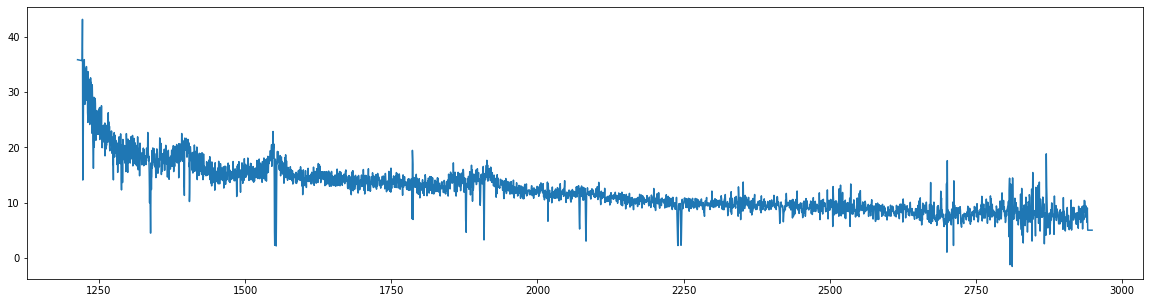

In [3]:
spec = readdr7('dr7data\spSpec-53142-1697-627.fit')
fig = figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(spec.restframe, spec.flux)

Choose two wavelength ranges next to the center of CIV doublets to calculate the normalization factor $n$, where there are no obvious emission and absorption lines.

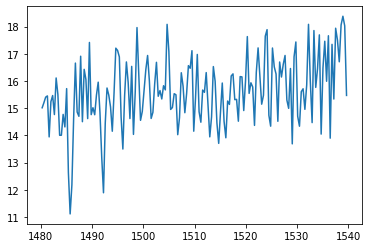

In [4]:
idx1 = where((spec.restframe.value>1480)*(spec.restframe.value<1540))
plot(spec.restframe[idx1],spec.flux[idx1])

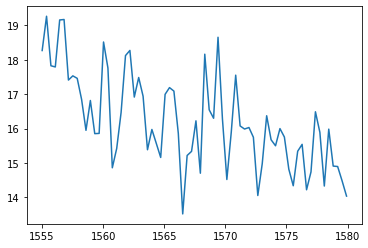

In [5]:
idx2 = where((spec.restframe.value>1555)*(spec.restframe.value<1580))
plot(spec.restframe[idx2],spec.flux[idx2])

In [6]:
#The function to normalize the flux
def normal_spec(flux):
    
    idx1 = where((spec.restframe.value>1480)*(spec.restframe.value<1540))
    idx2 = where((spec.restframe.value>1555)*(spec.restframe.value<1580))
    n = (sum(spec.flux[idx1])+sum(spec.flux[idx2]))/(len(idx1[0])+len(idx2[0]))

    flux = flux/n
    
    return flux 

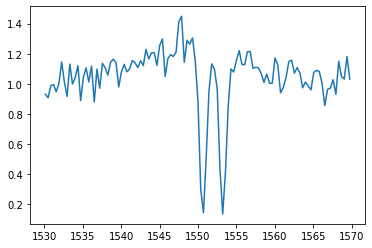

In [7]:
idx3 = where((spec.restframe.value>1530)*(spec.restframe.value<1570))
lam1 = spec.restframe[idx3].value
flux1 = normal_spec(spec.flux[idx3])
noise = spec.noise[idx3]

plot(lam1,flux1)
show()

Fit the curve

In [8]:
popt,pcov = curve_fit(Ilam,lam1,flux1,sigma=noise,p0=[2,30,30,2e14,2e14])
print(popt)
print('lgN1=',log(popt[3])/log(10))
print('lgN2=',log(popt[4])/log(10))

[2.46311731e+00 5.34138412e+01 5.53570914e+01 3.58084866e+14
 6.74861750e+14]
lgN1= 14.5539859665298
lgN2= 14.829214813635353


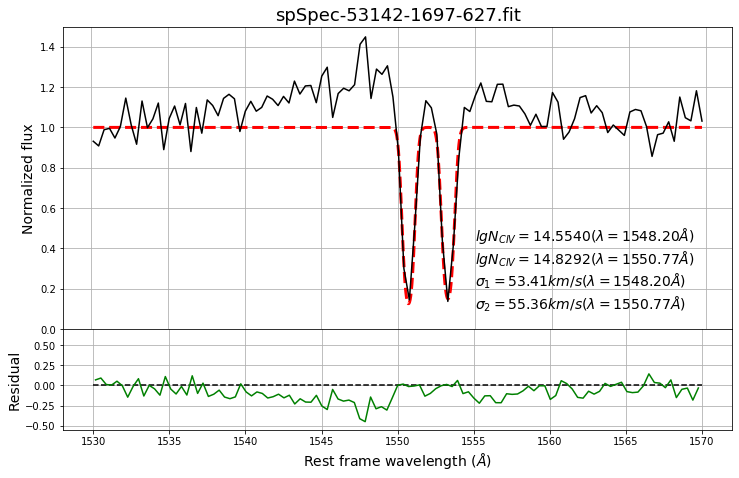

In [9]:
err = Ilam(lam1,*popt)-flux1
lamfit = linspace(min(lam1),max(lam1),1000)

fig = figure(figsize=(12,8))
ax1 = subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
subplots_adjust(bottom=0.1, top=1, hspace=1)
ax2 = subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4)
setp(ax1.get_xticklabels(), visible=False)
subplots_adjust(bottom=0.1, top=0.8, hspace=0)

ax1.plot(lamfit,Ilam(lamfit,*popt),'r--',linewidth = 3)
ax1.plot(lam1,flux1,'k')
ax2.plot(lam1,err,'green')
ax2.hlines(0,1530,1570, color = 'black',linestyles='--')

ax1.text(1555,0.1,r'$lgN_{CIV} = %.4f(\lambda = 1548.20 \AA)$'%(log(popt[3])/log(10))+'\n'
         +r'$lgN_{CIV} = %.4f (\lambda = 1550.77 \AA)$'%(log(popt[4])/log(10))+'\n'
         +r'$\sigma_1=%.2f km/s(\lambda = 1548.20 \AA)$'%popt[1]+'\n'
         +r'$\sigma_2=%.2f km/s(\lambda = 1550.77 \AA)$'%popt[2],fontsize = 14)

ax1.set_title(spec.name,fontsize = 18)
ax1.set_ylabel(r"Normalized flux",fontsize=14)
ax2.set_ylabel("Residual",fontsize=14)
ax2.set_xlabel("Rest frame wavelength ($\AA$)",fontsize=14)
ax1.set_ylim(0,1.5)
ax2.set_ylim(-0.55,0.7)

ax1.grid()
ax2.grid()

savefig('column density fitting of '+spec.name.split('.')[0]+'.png')

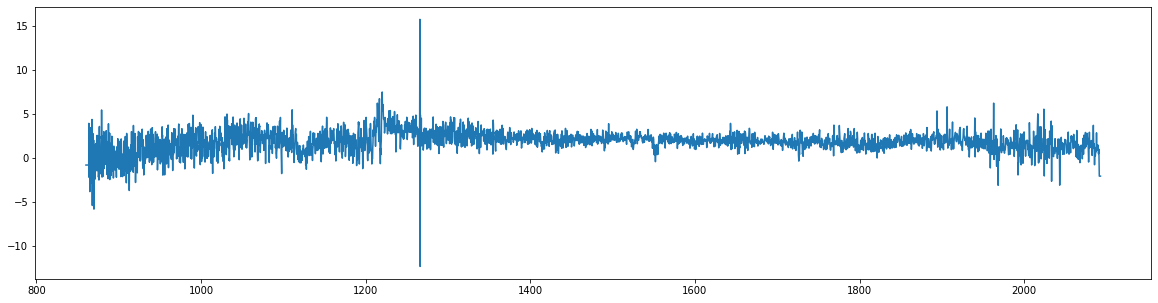

In [10]:
spec = readdr7('dr7data\spSpec-53473-2108-438.fit')
fig = figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(spec.restframe, spec.flux)

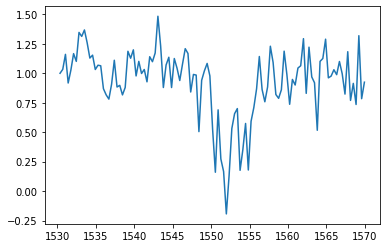

In [11]:
idx4 = where((spec.restframe.value>1530)*(spec.restframe.value<1570))
lam2 = spec.restframe[idx4].value
flux2 = normal_spec(spec.flux[idx4])
noise = spec.noise[idx4]

plot(lam2,flux2)
show()

In [12]:
popt,pcov = curve_fit(Ilam,lam2,flux2,p0=[3,100,100,1e14,1e14], sigma=noise, bounds=([-5, 0,0, 1e12,1e12], [5, 500,500, 1e16,1e16]))
print(popt)
print('lgN1=',log(popt[3])/log(10))
print('lgN2=',log(popt[4])/log(10))

[3.48883436e+00 1.29824150e+02 1.40737157e+02 1.10027239e+15
 1.07678960e+15]
lgN1= 15.041500213327204
lgN2= 15.032130852508352


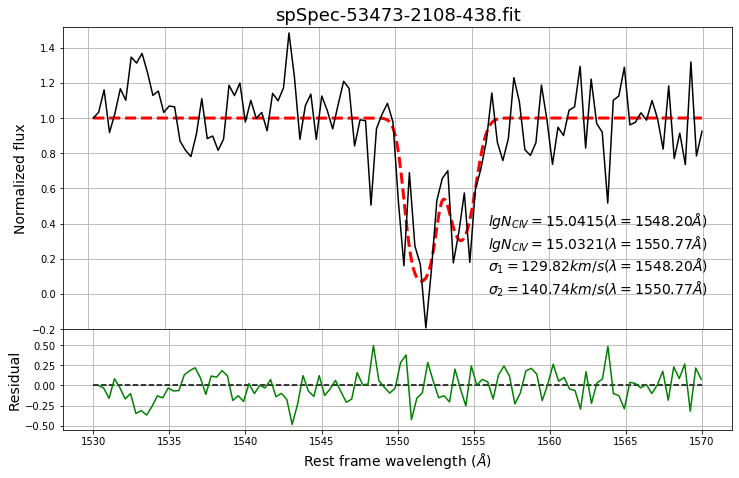

In [17]:
err = Ilam(lam2,*popt)-flux2
lamfit = linspace(min(lam2),max(lam2),1000)

fig = figure(figsize=(12,8))
ax1 = subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
subplots_adjust(bottom=0.1, top=1, hspace=1)
ax2 = subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4)
setp(ax1.get_xticklabels(), visible=False)
subplots_adjust(bottom=0.1, top=0.8, hspace=0)

ax1.plot(lamfit,Ilam(lamfit,*popt),'r--',linewidth = 3)
ax1.plot(lam2,flux2,'k')
ax2.plot(lam2,err,'green')
ax2.hlines(0,1530,1570, color = 'black',linestyles='--')

ax1.text(1556,0,r'$lgN_{CIV} = %.4f(\lambda = 1548.20 \AA)$'%(log(popt[3])/log(10))+'\n'
         +r'$lgN_{CIV} = %.4f (\lambda = 1550.77 \AA)$'%(log(popt[4])/log(10))+'\n'
         +r'$\sigma_1=%.2f km/s(\lambda = 1548.20 \AA)$'%popt[1]+'\n'
         +r'$\sigma_2=%.2f km/s(\lambda = 1550.77 \AA)$'%popt[2],fontsize = 14)

ax1.set_title(spec.name,fontsize = 18)
ax1.set_ylabel(r"Normalized flux",fontsize=14)
ax2.set_ylabel("Residual",fontsize=14)
ax2.set_xlabel("Rest frame wavelength ($\AA$)",fontsize=14)
ax1.set_ylim(-0.2,1.52)
ax2.set_ylim(-0.55,0.7)

ax1.grid()
ax2.grid()

savefig('column density fitting of '+spec.name.split('.')[0]+'.png')